In [35]:
import nengo
import numpy as np

class Player(object):
    def __init__(self, x, ys, max_y, color, goal_left):
        self.x = x
        self.ys = ys
        self.max_y = max_y
        self.offset = max_y / 2
        self.radius = 12
        self.max_radius = 30
        self.color = color
        self.rotate_offset = 0
        self.goal_left = goal_left
        self.kick_deg = 40
        self.velocity = 0
        
    def slide(self, dt, velocity):
        self.offset = np.clip(self.offset + velocity*dt, 0, self.max_y)
    
    def rotate(self, dt, velocity):
        self.velocity = velocity 
        self.rotate_offset = (self.rotate_offset + self.velocity*dt) % 360
        self.rot_off = self.rotate_offset 
        if (self.rotate_offset > 90 and self.rotate_offset < 180) or (
            self.rotate_offset > 270):
                self.rot_off = 90 - self.rotate_offset
        
    def collide(self, x, y):
        for player_y in self.ys:
            if self.rotate_offset < self.kick_deg or self.rotate_offset > 270 - self.kick_deg:
                delta_x = x - self.x
                delta_y = y - (player_y + self.offset)
                dist = np.sqrt(delta_x**2 + delta_y**2)
                if dist < self.radius:
                    return delta_x, delta_y
        return 0, 0
        
    def __rx(self):
        return self.radius + (self.rot_off % 90)/90 * (self.max_radius - self.radius)
      
    def __cx_off(self):
        return (self.rot_off % 90)/90 * 20 * (int(self.rotate_offset > 180)*2 - 1)
        
    def __opacity(self):
        if self.goal_left and self.rotate_offset > 0 and self.rotate_offset <= 180:
            return 0.5 
        elif not(self.goal_left) and self.rotate_offset > 180:
            return 0.5
        return 1 
        
    def svg(self):
        line_width=5
        
        players = ['<ellipse cx="{x}" cy="{y}" ry="{radius}" rx="{angle}" fill="{color}" fill-opacity="{opacity}"/>'.format(
            x=self.x - self.__cx_off(), y=yy+self.offset, radius=self.radius, angle=self.__rx(), color=self.color, opacity=self.__opacity()) for yy in self.ys]
        
        return '''
        <rect x="{x0}" y="0" width="{line_width}" height="{height}" fill="silver"/>
        {players}
        
        '''.format(x0=self.x-line_width/2, players=''.join(players), line_width=line_width, height=self.table.height)

class Foosball(object):
    def __init__(self, ball_noise=0, seed=None):
        self.width = 800
        self.height = 400
        self.ball_radius = 12
        self.ball_noise = ball_noise
        self.rng = np.random.RandomState()
        
        self.score = np.zeros(2)
        self.reset_ball()
        
        self.players = []
        
    def add_player(self, player):
        player.table = self
        self.players.append(player)
        
    def reset_ball(self):
        self.ball_pos = np.array([self.width/2, self.height/2])
        #self.ball_vel = np.array([-1000, 0])
        self.ball_vel = self.rng.uniform(-1000, 1000, 2)
        
    def step(self, dt, slide):
        if self.ball_noise is not None:
            self.ball_vel += self.rng.normal(loc=0, scale=self.ball_noise, size=2)
            
        self.ball_pos += self.ball_vel*dt  
        
        #if self.ball_pos[0]-self.ball_radius < 0 and self.height/3 < self.ball_pos[1] < 2*self.height/3:
        #    self.score[0] += 1
        #    self.reset_ball()
        #if self.ball_pos[0]+self.ball_radius > self.width and self.height/3 < self.ball_pos[1] < 2*self.height/3:
        #    self.score[1] += 1
        #    self.reset_ball()
        
        
        if self.ball_pos[0]-self.ball_radius < 0:
            self.ball_pos[0] = self.ball_radius
            self.ball_vel[0] *= -1
        if self.ball_pos[1]-self.ball_radius < 0:
            self.ball_pos[1] = self.ball_radius
            self.ball_vel[1] *= -1
        if self.ball_pos[0]+self.ball_radius > self.width:
            self.ball_pos[0] = self.width - self.ball_radius
            self.ball_vel[0] *= -1
        if self.ball_pos[1]+self.ball_radius > self.height:
            self.ball_pos[1] = self.height - self.ball_radius
            self.ball_vel[1] *= -1
            
        for i, p in enumerate(self.players):
            p.slide(dt=dt, velocity=slide[i*2])
            p.rotate(dt=dt, velocity=slide[i*2+1])
            cx, cy = p.collide(self.ball_pos[0], self.ball_pos[1])
            self.ball_pos += [cx, cy]
            new_v = np.array([cx, cy])
            v_norm = np.linalg.norm(new_v)
            if v_norm > 0:
                mag = np.linalg.norm(self.ball_vel)
                self.ball_vel = mag * new_v / v_norm + p.velocity
        
    def svg(self, prediction=None):
        if prediction is None:
            pred_path = ''
            pred_y = 0
        else:
            prediction, pred_y = prediction[:-1], prediction[-1]
            
            pred = prediction.reshape(len(prediction)//2, 2)
            pred_path = ''.join(['<circle cx="{x}" cy="{y}" fill="white", r="2" />'.format(x=p[0], y=p[1]) for p in pred])

        template = '''<svg width="100%" height="100%" viewbox="0 0 {width} {height}">

        <rect x="0" y="0" height="{height}" width="{width}" fill="green"/>
        <rect x="0" y="{goal_height}" height="{goal_height}" width="10" fill="yellow"/>
        <rect x="{goal2width}" y="{goal_height}" height="{goal_height}" width="10" fill="lightblue"/>
        
        <rect x="0", y="{pred_y}" height="10" width="50" fill="yellow" />

        {players}

        <circle cx="{bx}" cy="{by}" fill="white" r="{ball_radius}" />
        <text x="10" y="100" style="font:bold 80px sans-serif">{score0}</text>
        <text x="{score2width}" y="100" style="font:bold 80px sans-serif">{score1}</text>
        
        {pred_path}

        </svg>'''.format(width=self.width, height=self.height, 
                         bx=self.ball_pos[0], by=self.ball_pos[1], 
                         ball_radius=self.ball_radius,
                         goal2width=self.width-10,
                         score2width=self.width-100,
                         score0=int(self.score[0]),
                         score1=int(self.score[1]),
                         players=''.join([p.svg() for p in self.players]),
                         goal_height=self.height/3,
                         pred_y=pred_y,
                        pred_path=pred_path)

        return template
        
    def act(self, time, action_vector):
        # b = blue, y = yellow, s = slide, r = rotate
        # action_vector = [b_s_goalie, b_r_goalie, 
        # b_s_defenders, b_r_defenders, 
        # b_s_midfield, b_r_midfield, 
        # b_s_strikers, b_r_strikers]
        # + same for yellows
        
        self.step(time, action_vector)
        
        return self.score, self.svg(), np.array([[p.offset, p.rotate_offset] for p in self.players]).flatten()





In [17]:
def run_once(T, dt, ball_noise=10):
    foosball = Foosball(ball_noise=ball_noise)
    p = []
    v = []
    for i in range(int(T/dt)):
        foosball.step(dt, [])
        p.append(foosball.ball_pos.copy())
        v.append(foosball.ball_vel.copy())
    return np.array(p), np.array(v)
    
p, v = run_once(T=10.0, dt=0.01)    
    
    

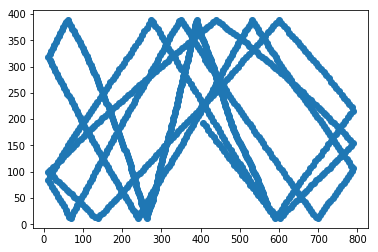

In [18]:
%matplotlib inline
import pylab
pylab.scatter(p[:,0], p[:,1])

In [19]:
hit_left = np.where(p[:,0]<50, True, False)
y = p[hit_left,1]
hit_num = np.cumsum(hit_left)
valid_hit_num = hit_num[hit_num<len(y)]
y_target = y[valid_hit_num]


In [73]:
def make_data(T=10, dt=0.01, T_future=2, dt_pred=0.1, ball_noise=10, runs=10, skip=1):
    inputs = []
    outputs = []
    
    for run in range(runs):
        p, v = run_once(T=T, dt=dt, ball_noise=ball_noise)
        
        hit_left = np.where(p[:,0]<50, True, False)
        y = p[hit_left,1]
        hit_num = np.cumsum(hit_left)
        valid_hit_num = hit_num[hit_num<len(y)]
        y_target = y[valid_hit_num]        
        
        
        t = np.arange(len(p))*dt
        spacing = int(dt_pred/dt)
        pred_steps = int(T_future/dt_pred)
        offsets = (np.arange(pred_steps)+1)*spacing

        for i in range(0,len(t)-offsets[-1], skip):
            input = [p[i][0], p[i][1], v[i][0], v[i][1]]
            output = p[i+offsets].flatten()
            if i < len(y_target):
                output = np.hstack([output, y_target[i]])
                inputs.append(input)
                outputs.append(output)
        
    return np.array(inputs), np.array(outputs)

dt_pred=0.04  # use data points every 40 ms.
T_future=1.0
inp, outp = make_data(runs=4000, skip=10, dt_pred=dt_pred, T_future=T_future)  # runs was 500

    

In [64]:
print(outp.shape)

In [65]:
inp_mean = np.mean(inp, axis=0)
inp_sd = np.std(inp, axis=0)
outp_mean = np.mean(outp, axis=0)
outp_sd = np.std(outp, axis=0)

def inp2inpz(x):
    return (x-inp_mean[None,:])/inp_sd[None,:]
def outp2outpz(x):
    return (x-outp_mean[None,:])/outp_sd[None,:]
def inpz2inp(x):
    return x*inp_sd[None,:]+inp_mean[None,:]
def outpz2outp(x):
    return x*outp_sd[None,:]+outp_mean[None,:]

inp_z = inp2inpz(inp)
outp_z = outp2outpz(outp)

In [66]:
import nengo
model = nengo.Network()
with model:
    output = nengo.Node(None, size_in=outp.shape[1])
    ens = nengo.Ensemble(n_neurons=2000, dimensions=inp.shape[1], neuron_type=nengo.LIFRate(), radius=2, seed=1)
    conn = nengo.Connection(ens, output, eval_points=inp_z, function=outp_z, synapse=None, scale_eval_points=False,
                            solver=nengo.solvers.LstsqL2(reg=0.00001))
sim = nengo.Simulator(model)
print(sim.data[conn].solver_info['rmses'])

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [67]:
test_inp, test_outp = make_data(runs=10, dt_pred=dt_pred, T_future=T_future)
test_inp_z = inp2inpz(test_inp)
dec = sim.data[conn].weights
_, A = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=test_inp_z)
pred_outp = outpz2outp(np.dot(A, dec.T))

In [68]:
np.savez('prediction_decoder', dec=dec)

In [69]:
error = (pred_outp-test_outp)
rmse = np.sqrt(np.mean(error**2, axis=0))

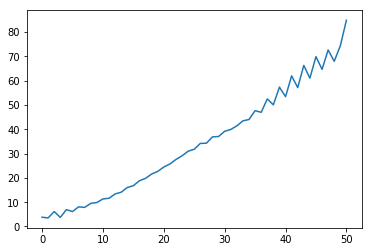

In [70]:
pylab.plot(rmse)

In [71]:
foosball = Foosball(ball_noise=0)

def foosball_node(t, x):
    foosball.step(0.001, slide=[])
    foosball_node._nengo_html_ = foosball.svg(prediction=outpz2outp([x])[0])
    output = np.array([foosball.ball_pos[0], foosball.ball_pos[1], foosball.ball_vel[0], foosball.ball_vel[1]])
    return inp2inpz([output])[0]

model = nengo.Network()

with model:
    f = nengo.Node(foosball_node, size_in=outp.shape[1])
    model.add(ens)
    conn = nengo.Connection(ens.neurons, f, transform=dec, synapse=None)
    
    #conn = nengo.Connection(ens, f, eval_points=inp_z, function=outp_z, synapse=None, scale_eval_points=False)
    nengo.Connection(f, ens, synapse=0)
    
    

In [72]:
import nengo_gui.ipython
nengo_gui.ipython.IPythonViz(model, cfg='foosball3.cfg')

d:\tellurideworkshop\telluride2018\nengo-gui\nengo_gui\ipython.py:63: ConfigReuseWarning: Reusing config. Only the most recent visualization will update the config.
  "Reusing config. Only the most recent visualization will "


In [13]:
np.linalg.norm(inp_z, axis=1)

array([1.59247725, 1.57546405, 1.56751226, ..., 2.49480879, 2.47005396,
       2.42732832])

In [91]:
inp_mean

149.01020460508298